## CS 109B/STAT 121B/AC 209B/CSCI E-109B: Homework 5
### Neural Net Basics & Feed-forward Nets
** Harvard University ** <br>
** Spring  2018 ** <br>
** Instructors:** Pavlos Protopapas and Mark Glickman 

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109B, 121B, 209B, or E109B):

In [2]:
import sys

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import time

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



## Learning fractal patterns using neural networks

You are provided a dataset with two covariates and a binary response variable. The training and test samples are provided in the files `fractal_train.txt` and `fractal_test.txt` respectively, and a sample for validation is provided in the file `fractal_vali.txt`.  

The data points lie in a square of dimension 1$\times$1 and form a Sierpinski triangle. A Sierpinski triangle is a fractal pattern that reveals the same triangular pattern across different scales. The following <a href=https://en.wikipedia.org/wiki/Sierpinski_triangle>Wikipedia page</a> has a detailed description of Sierpinski triangles. The label-1 points are distributed uniformly across the fractal pattern, and the label-0 points are distributed uniformly across the entire square.


A Sierpinski triangle can be generated at different depths or *scales*. For example, the following image from Wiki shows Sierpinski triangles generated at scales 0, 1, 2, 3 and 4:
<center>
<img src = "https://upload.wikimedia.org/wikipedia/commons/0/05/Sierpinski_triangle_evolution.svg">
</center>

Notice that the larger the scale, the more difficult it is to model the pattern, making this dataset an ideal candidate to study and understand multilayer feedforward neural networks. In the dataset provided, the Sierpinski triangle has been generated at a scale of 5. We expect  a reasonable classifier for this dataset to be able to yield a classification accuracy of at least 80%. The theoretical best accuracy that can be achieved on this dataset is ~94%. 

The following are the main learning outcomes from this homework:
- Model, train, and evaluate feedforward neural networks in `Keras`
- Explore different network architectures, and analyze how the depth and width of a network effects its performance
- Understand and apply regularization to neural networks
- Compare the performance neural networks with other standard machine learning algorithms

You may use the following function to visualize the decision boundaries of the trained models.

## Part 0: Visualize data (5pts)

1. Read the data and use the `plot_data` from `HW5_functions.py` to visualize the data. `plot_data` takes the following parameters: `plot_data(x, y, ax, title)`, where `x` are the predictors and `y` are the labels.
Your answer should contain two plots: one for the training data, and one for the test data. Each plot should have the axes labeled, contain a title, and a color-coded legend for the positive and negative examples.

In [3]:
# starter code
from HW5_functions import plot_data

('Train data size', (1000, 2))
('Test data size', (1000, 2))
('Validation data size', (1000, 2))


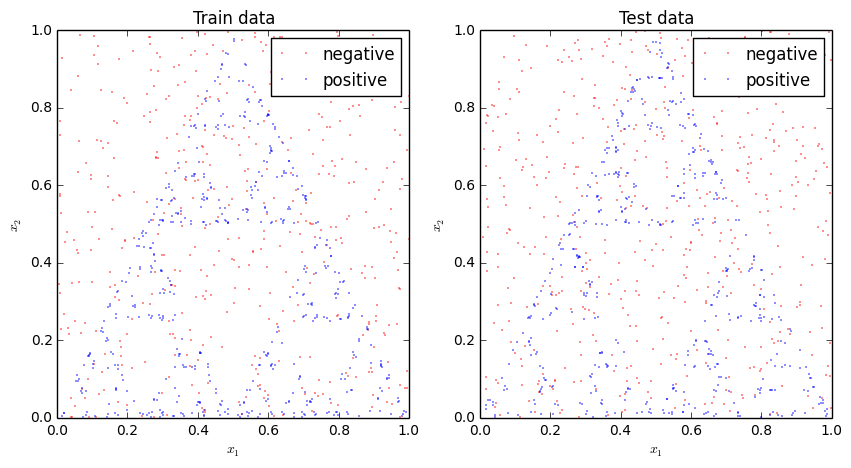

In [4]:
data_train = np.loadtxt('fractal_train.txt', delimiter=',')
x_train = data_train[:,0:2]
y_train = data_train[:,-1]

data_test = np.loadtxt('fractal_test.txt', delimiter=',')
x_test = data_test[:,0:2]
y_test = data_test[:,-1]

data_vali = np.loadtxt('fractal_vali.txt', delimiter=',')
x_vali = data_vali[:,0:2]
y_vali = data_vali[:,-1]

_,ax = plt.subplots(1,2, figsize=(10,5))

print('Train data size', x_train.shape)
print('Test data size', x_test.shape)
print('Validation data size', x_vali.shape)

plot_data(x_train, y_train, ax[0], 'Train data')
plot_data(x_test, y_test, ax[1], 'Test data')

## Part 1: Evaluate baselines (10pts) 

1. Fit the following machine learning models to the training sample and evaluate their classification accuracies on the test sample.
    - Linear Logistic Regression
    - Support Vector Machine (with RBF kernel)
    - Random Forest

2. In each case, visualize the decision boundaries learned by the models using the `plot_decision_boundary` from `HW5_functions`.

Do not forget to tune the relevant hyper-parameters using cross-validation on the training set. The parameters you may consider include the `regularization parameter` in logistic regression, the `regularization parameter` and `kernel width` in SVM and the `maximum tree depth` and `number of estimators` in random forest.

Your answer should include three decision boundary plots (one for each model), with the training and testing classification accuracies for each printed in the title.

In [5]:
# starter code
from HW5_functions import plot_decision_boundary

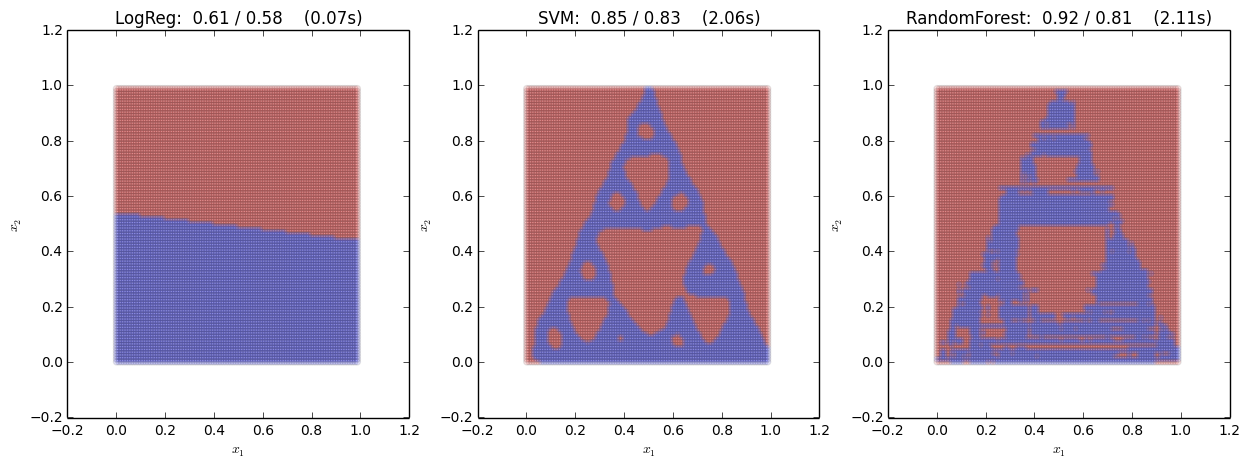

In [5]:
_, ax = plt.subplots(1, 3, figsize=(15,5))

# Evaluate linear logistic regression
start = time.clock()
model = LogisticRegressionCV()
model.fit(x_train, y_train)
stop = time.clock()

run_time = stop - start
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

plot_decision_boundary(x_test, y_test, model,\
                           'LogReg:  ' + '{:.2f}'.format(tr_acc)\
                           + ' / ' + '{:.2f}'.format(ts_acc)\
                           + '    (' + '{:.2f}'.format(run_time) + 's)',\
                           ax[0])

# Evaluate RBF SVM
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1, 10, 1e2],
                    'C': [1e-2, 1e-1, 1, 10, 1e2]}]

# Append train and vali sets
nt = x_train.shape[0]
nv = x_vali.shape[0]
cv_iterator = [(np.arange(0, nt), np.arange(0, nv))]
x = np.append(x_train, x_vali, axis=0)
y = np.append(y_train, y_vali, axis=0)

start = time.clock()
clf = GridSearchCV(SVC(), tuned_parameters, cv=cv_iterator)
clf.fit(x, y)
model = clf.best_estimator_
stop = time.clock()

run_time = stop - start
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

plot_decision_boundary(x_test, y_test, model,\
                           'SVM:  ' + '{:.2f}'.format(tr_acc)\
                           + ' / ' + '{:.2f}'.format(ts_acc)\
                           + '    (' + '{:.2f}'.format(run_time) + 's)',\
                           ax[1])

# Evaluate Random Forest
tuned_parameters = {"max_depth": [3, 5, 7, 9, 11]
                        ,"n_estimators" : [10, 20, 30]}
start = time.clock()
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=cv_iterator)
clf.fit(x, y)
model = clf.best_estimator_
stop = time.clock()

run_time = stop - start
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

plot_decision_boundary(x_test, y_test, model,\
                           'RandomForest:  ' + '{:.2f}'.format(tr_acc)\
                           + ' / ' + '{:.2f}'.format(ts_acc)\
                           + '    (' + '{:.2f}'.format(run_time) + 's)',\
                           ax[2])

## Part 2: Train feedforward net with 1 hidden layer (25pts)

1. Fit a feed-forward neural network with a single hidden layer to the training set and evaluate its classification accuracy on the test set. Using suitable visualizations, explain how the number of nodes in the hidden layer effects the training and test performance of the neural network, and the shape of decision boundary learned by the network.
2. Using suitable visualizations, explain how the number of nodes in the hidden layer affects the training and test performance of the neural network, and the shape of decision boundary learned by the network.

*Hints:* 
- It is usually recommended that you set the batch size in the optimization algorithm to a power of 2 (can you foresee the benfit of doing this?)
- When we trained a neural network with a single hidden layer of 100 nodes, with ReLU activation functions in the hidden layers, and with the binary cross-entropy as the loss function, we observed a training time of ~2 minutes for 2000 iterations of the Adam solver with learning rate 0.001 and batch size 64.
- Use `plot_learning_curve` from `HW5_functions` to visualize the train/test accurancies.

Your answer should fit and evaluate the network for at least two different numbers of nodes in the hidden layer. For each of these different node values, plot a. the decision boundary, and b. the learning curve. Be sure to train your networks until the learning curves demonstrate clear convergence. For #2, include a brief written explanation of your answer.

*Solution*: We stop solver when change in validation accuracy is less than 0.0001 for 500 iterations

In [6]:
# starter code
from HW5_functions import plot_learning_curve
from HW5_functions import NBatchLogger

In [20]:
#--------  fit_nn
# A function to fit neural network to (x_train, y_train), 
#     using (x_vali, y_vali) as the validation test, 
#     and evaluate accuracy on (x_test, y_test)
# Input: 
#      (x_train, y_train), (x_vali, y_vali), (x_test, y_test)
#      param

def fit_nn(x_train, y_train, x_vali, y_vali, x_test, y_test, param):
    # Construct neural network model
    model = Sequential()
    num_classes = 2
    
    # first hidden layer

    model.add(Dense(param['num_hidden_nodes'], input_dim=x_train.shape[1]))
    model.add(Activation('relu')) 
    if param['dropout_rate'] > 0:
            model.add(Dropout(param['dropout_rate']))
    
    for i in range(1,param['num_layers']-1):
        # Fully-connected hidden layer i
        model.add(Dense(param['num_hidden_nodes']))
        model.add(Activation('relu')) 
        if param['dropout_rate'] > 0:
            model.add(Dropout(param['dropout_rate'])) # include dropout

    # Fully-connected output layer with 'num_classes' nodes and a softmax activation
    model.add(Dense(1,activation='sigmoid'))

    # Choose optimizer
    adam = Adam(lr = param['learning_rate']) # Adam solver
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    # Fit neural network
    # To log history:
    out_batch = NBatchLogger(param['logging_epochs'], x_test, y_test, model)
    
    # To save best model:
    filepath="weights-best-{}-{}-{}.hdf5".format(param['num_layers'], 
                                              param['num_hidden_nodes'],
                                              param['num_iterations'])
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                                 save_best_only=True, mode='max')
    
    # Record run-time
    start = time.clock()
    if param['use_convergence_test']: # Stop solver when val accuracy < 0.0001 for 500 iterations
        e_stop = EarlyStopping(monitor='acc', min_delta=0.0001,
                           patience=500, verbose=0, mode='max')
        result = model.fit(x_train, y_train,\
                       epochs = param['num_iterations'],\
                       verbose = 0,\
                       batch_size = param['batch_size'],\
                       callbacks=[out_batch, e_stop, checkpoint],\
                       validation_data=(x_vali, y_vali))
    else:
        result = model.fit(x_train, y_train,\
                       epochs = param['num_iterations'],\
                       verbose = 0,\
                       batch_size = param['batch_size'],\
                       callbacks=[out_batch, checkpoint],\
                       validation_data=(x_vali, y_vali))
    stop = time.clock()
    
    # Train and test accuracies
    if ~param['last_model']: # Output model with highest validation accuracy
        model.load_weights(filepath)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])    
    
    score = model.evaluate(x_train, y_train, verbose=0)
    acc = score[1]

    score = model.evaluate(x_test, y_test, verbose=0)
    val_acc = score[1]
    
    return model, result, acc, val_acc, stop - start

(1,10)
500: 0.649 / 0.642
1000: 0.691 / 0.687
1500: 0.707 / 0.694
2000: 0.713 / 0.695
2500: 0.712 / 0.695
(1,100)
500: 0.758 / 0.742
1000: 0.766 / 0.743
1500: 0.770 / 0.744
2000: 0.784 / 0.754
2500: 0.800 / 0.769
3000: 0.798 / 0.775


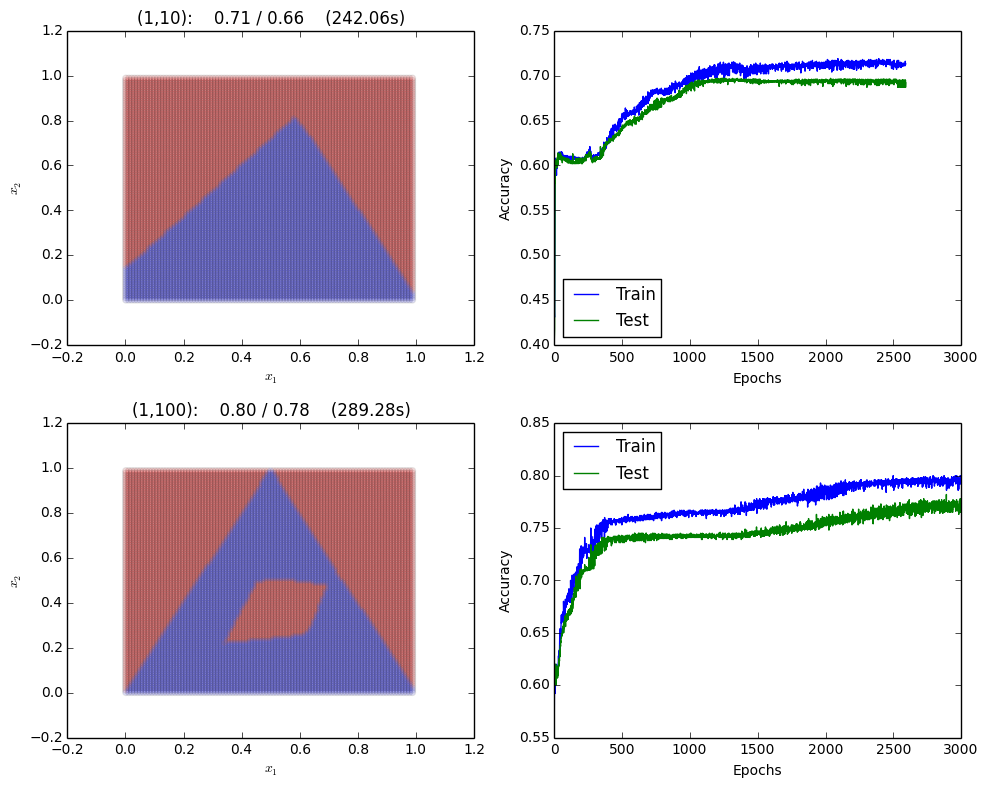

In [21]:
param = {}

param['dropout_rate'] = 0
param['learning_rate'] = 0.001
param['batch_size'] = 64
param['num_iterations'] = 10000
param['logging_epochs'] = 500
param['num_layers'] = 1 # 1 hidden layer

param['use_convergence_test'] = True
param['last_model'] = True

num_hidden_nodes = [10,100]

_, ax = plt.subplots(len(num_hidden_nodes), 2,
                     figsize=(10,len(num_hidden_nodes)*4))

log_part2 = [param]

for i in range(len(num_hidden_nodes)):
    param['num_hidden_nodes'] = num_hidden_nodes[i]
    
    print('(1,' + str(param['num_hidden_nodes']) + ')')
        
    model, results, acc, val_acc, run_time =\
                fit_nn(x_train, y_train, x_vali, y_vali, x_test, y_test, param)
            
    plot_decision_boundary(x_test, y_test, model,\
                           '(1,'\
                           + str(param['num_hidden_nodes']) + ')'\
                           + ':    ' + '{:.2f}'.format(acc)\
                           + ' / ' + '{:.2f}'.format(val_acc)\
                           + '    (' + '{:.2f}'.format(run_time) + 's)',\
                           ax[i][0])
    
    plot_learning_curve(results, ax[i][1])
    
    log_part2.append((model, results, acc, val_acc, run_time))

plt.tight_layout()

## Part 3: To go deeper or wider? (25pts) 

We shall now consider neural network models with more than one hidden layer. Fixing the total number of hidden nodes across all layers to 500, train and evaluate the following network architectures with varying depths:

- 2 layers with 250 nodes each
- 3 layers with 166 nodes each
- 4 layers with 125 nodes each
- 5 layers with 100 nodes each

What is the effect of depth and width of the network on the training and test accuracies?

Based on your observations, what would be a good rule-of-thumb for choosing the appropriate network architecture? Support your answers with suitable visualizations.

*Hint*: When we trained a neural network with 3 hidden layer and 166 nodes in each layer, with ReLU activation functions in the hidden layers, and with the binary cross-entropy as the loss function, we observed a training time of ~6 minutes for ~2000 iterations of the Adam solver with learning rate of 0.001 and batch size of 64.

Your answer should contain 2 plots (decision boundary and learning curve) for each of the four networks. Please indicate in #2 the trends and behaviors you observe as the parameters change. Using these observations, justify your answer in #3 with a brief written explanation.

*Solution*: We stop solver when change in validation accuracy is less than 0.0001 for 500 iterations

(2, 250)
1000: 0.790 / 0.766
2000: 0.787 / 0.765
(3, 166)
1000: 0.824 / 0.718
2000: 0.839 / 0.794
3000: 0.850 / 0.784
4000: 0.835 / 0.788
(4, 125)
1000: 0.830 / 0.771
2000: 0.865 / 0.731
3000: 0.885 / 0.772
4000: 0.914 / 0.756
5000: 0.919 / 0.781
6000: 0.941 / 0.780
7000: 0.954 / 0.774
(5, 100)
1000: 0.865 / 0.789
2000: 0.912 / 0.767
3000: 0.924 / 0.768
4000: 0.942 / 0.780


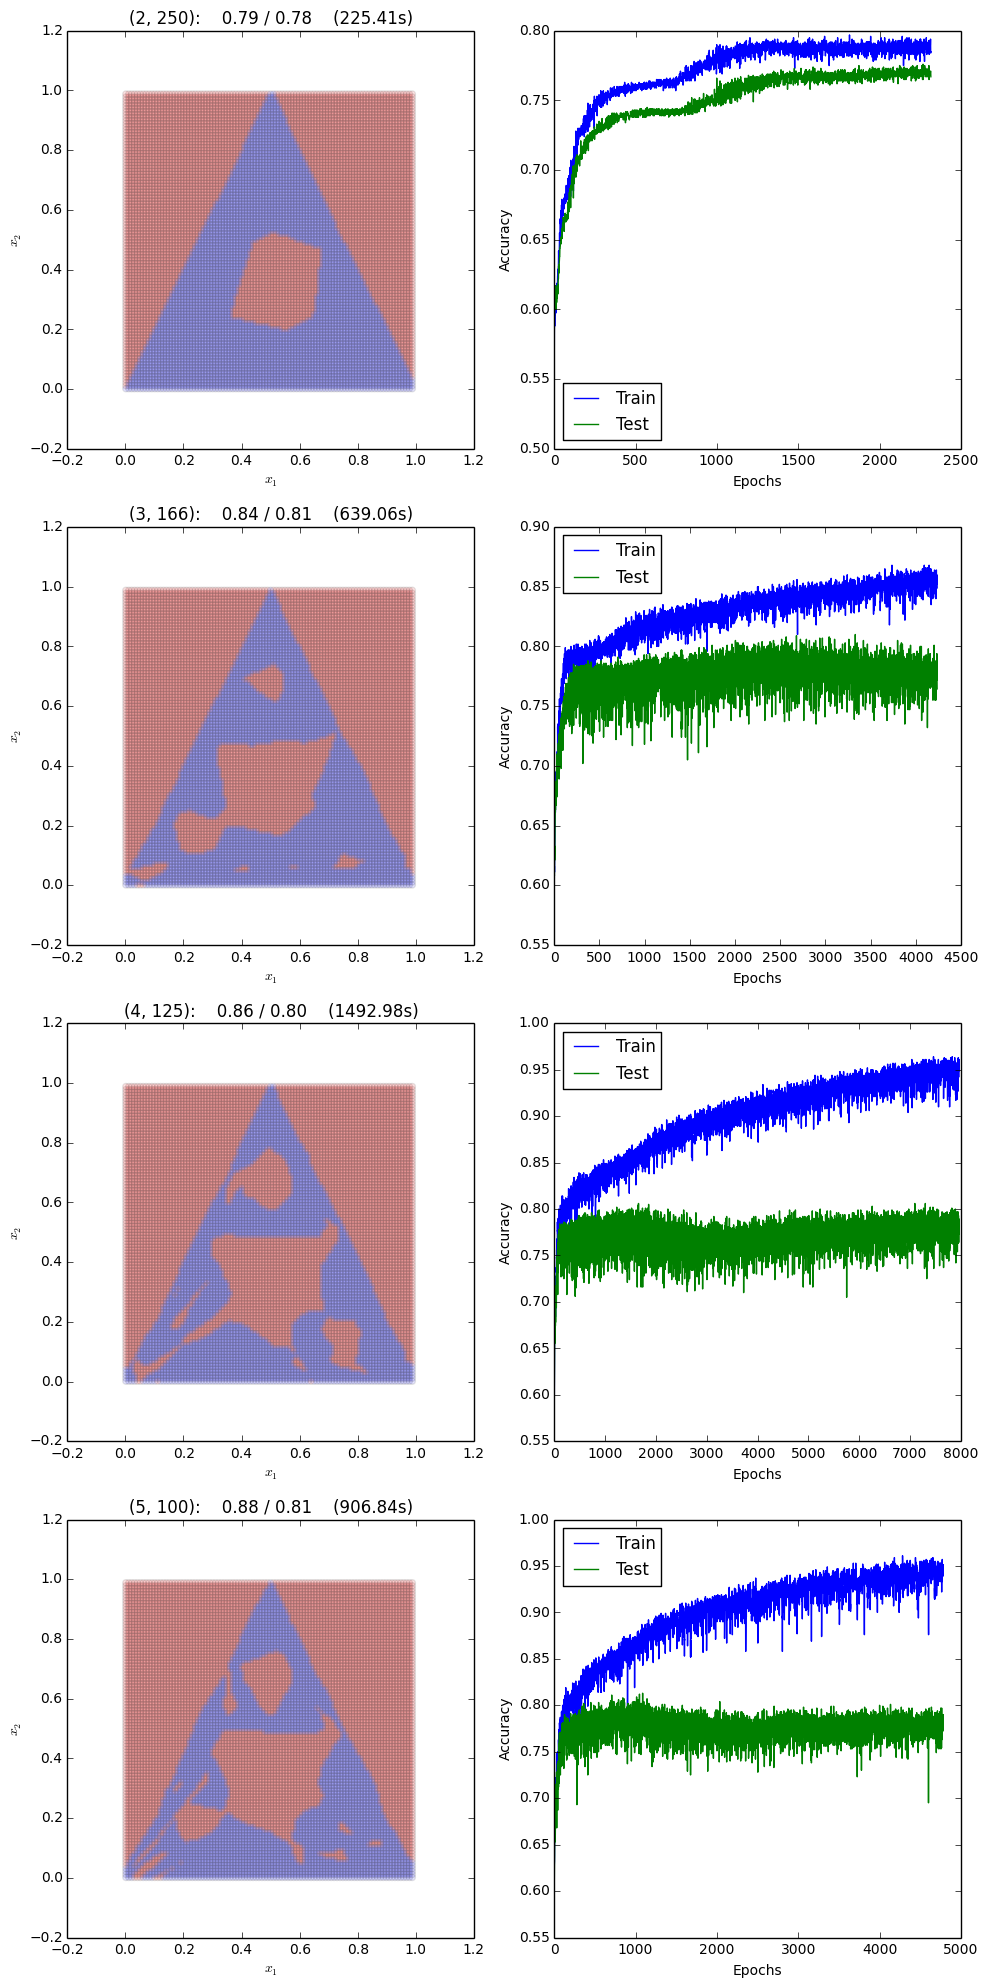

In [22]:
param = {}

param['dropout_rate'] = 0
param['learning_rate'] = 0.001
param['batch_size'] = 64
param['num_iterations'] = 10000
param['logging_epochs'] = 1000

param['max_layers'] = 5
param['max_nodes'] = 500

param['use_convergence_test'] = True
param['last_model'] = True

_, ax = plt.subplots(param['max_layers']-1, 2,
                     figsize=(10, param['max_layers']*4))

log_part3 = [param]

for num_layers in range(2, param['max_layers']+1):
    param['num_layers'] = num_layers
    param['num_hidden_nodes'] = int(param['max_nodes'] / num_layers)
    
    print( '(' + str(num_layers) + ', ' + str(param['num_hidden_nodes']) + ')')
        
    model, results, acc, val_acc, run_time =\
                fit_nn(x_train, y_train, x_vali, y_vali, x_test, y_test, param)
            
    plot_decision_boundary(x_test, y_test, model,\
                           '(' + str(num_layers) + ', '\
                           + str(param['num_hidden_nodes']) + ')'\
                           + ':    ' + '{:.2f}'.format(acc)\
                           + ' / ' + '{:.2f}'.format(val_acc)\
                           + '    (' + '{:.2f}'.format(run_time) + 's)',\
                           ax[num_layers-2][0])
    
    plot_learning_curve(results, ax[num_layers-2][1])
    
    log_part3.append((model, results, acc, val_acc, run_time))

plt.tight_layout()
plt.show()

## Part 4: Does regularization help? (25pts) 

Let us next explore if the use of regularization techniques can improve the test performance achieved in the previous parts. 
1. Choose a sufficiently complex neural network architecture (two or more hidden layers, and 100 or more nodes per layer), and train the network with one or more regularization techniques of your choice.  You are encouraged to try out different forms of regularization, but it is sufficient that you report results with one of the techniques. Report the training and testing accuracies.
2. Are you able to achieve higher test accuracies than the models learned in parts 1-3? Give a concrete explanation for your observations.

https://keras.io/regularizers/ and https://keras.io/constraints/ contain references to common regularization methods available in Keras.

Your answer should include at least two different regularization attempts (different techniques, parameters, etc.) and contain the decision boundary and learning curve plots for each. In \#2, please explain why regularization might be improving (or hurting) your test accuracy compared to previous models.

*Solution*: **Early stopping**: Pick model that yields highest validation accuracy across solver iterations. Also, stop solver when change in validation accuracy is less than 0.0001 for 500 iterations

In [27]:
#--------  fit_nn
# A function to fit neural network to (x_train, y_train), 
#     using (x_vali, y_vali) as the validation test, 
#     and evaluate accuracy on (x_test, y_test)
# Input: 
#      (x_train, y_train), (x_vali, y_vali), (x_test, y_test)
#      param

def fit_nn(x_train, y_train, x_vali, y_vali, x_test, y_test, param):
    # Construct neural network model
    model = Sequential()
    num_classes = 2
    
    # first hidden layer

    model.add(Dense(param['num_hidden_nodes'], input_dim=x_train.shape[1], kernel_regularizer=l2(0.001)))
    model.add(Activation('relu')) 
    if param['dropout_rate'] > 0:
            model.add(Dropout(param['dropout_rate']))
    
    for i in range(1,param['num_layers']-1):
        # Fully-connected hidden layer i
        model.add(Dense(param['num_hidden_nodes'], kernel_regularizer=l2(0.001)))
        model.add(Activation('relu')) 
        if param['dropout_rate'] > 0:
            model.add(Dropout(param['dropout_rate'])) # include dropout

    # Fully-connected output layer with 'num_classes' nodes and a softmax activation
    model.add(Dense(1,activation='sigmoid'))

    # Choose optimizer
    adam = Adam(lr = param['learning_rate']) # Adam solver
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    # Fit neural network
    # To log history:
    out_batch = NBatchLogger(param['logging_epochs'], x_test, y_test, model)
    
    # To save best model:
    filepath="weights-best-{}-{}-{}.hdf5".format(param['num_layers'], 
                                              param['num_hidden_nodes'],
                                              param['num_iterations'])
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                                 save_best_only=True, mode='max')
    
    # Record run-time
    start = time.clock()
    if param['use_convergence_test']: # Stop solver when val accuracy < 0.0001 for 500 iterations
        e_stop = EarlyStopping(monitor='acc', min_delta=0.0001,
                           patience=500, verbose=0, mode='max')
        result = model.fit(x_train, y_train,\
                       epochs = param['num_iterations'],\
                       verbose = 0,\
                       batch_size = param['batch_size'],\
                       callbacks=[out_batch, e_stop, checkpoint],\
                       validation_data=(x_vali, y_vali))
    else:
        result = model.fit(x_train, y_train,\
                       epochs = param['num_iterations'],\
                       verbose = 0,\
                       batch_size = param['batch_size'],\
                       callbacks=[out_batch, checkpoint],\
                       validation_data=(x_vali, y_vali))
    stop = time.clock()
    
    # Train and test accuracies
    if ~param['last_model']: # Output model with highest validation accuracy
        model.load_weights(filepath)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])    
    
    score = model.evaluate(x_train, y_train, verbose=0)
    acc = score[1]

    score = model.evaluate(x_test, y_test, verbose=0)
    val_acc = score[1]
    
    return model, result, acc, val_acc, stop - start

(5, 100)
1000: 0.794 / 0.730


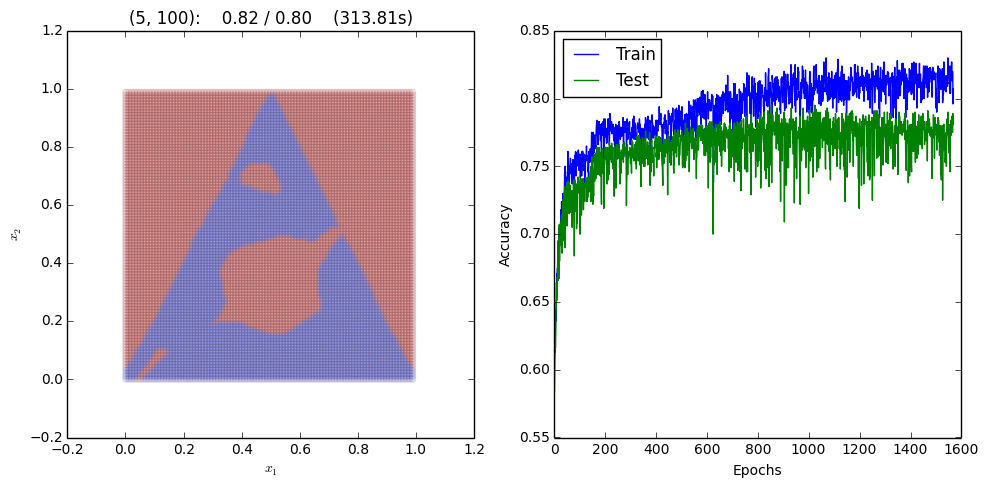

In [28]:
np.random.seed(10000)

param = {}

param['dropout_rate'] = 0.0
param['learning_rate'] = 0.001
param['batch_size'] = 64
param['num_iterations'] = 100000
param['logging_epochs'] = 1000

param['num_layers'] = 5
param['num_hidden_nodes'] = 100

# Early stopping, with check for convergence
param['use_convergence_test'] = True
param['last_model'] = False

print '(' + str(param['num_layers']) + ', ' + str(param['num_hidden_nodes']) + ')'

model, results, acc, val_acc, run_time =\
            fit_nn(x_train, y_train, x_vali, y_vali, x_test, y_test, param)

_, ax = plt.subplots(1, 2, figsize=(10,5))

plot_decision_boundary(x_test, y_test, model,\
                       '(' + str(param['num_layers']) + ', '\
                       + str(param['num_hidden_nodes']) + ')'\
                       + ':    ' + '{:.2f}'.format(acc)\
                       + ' / ' + '{:.2f}'.format(val_acc)\
                       + '    (' + '{:.2f}'.format(run_time) + 's)',\
                       ax[0])

plot_learning_curve(results, ax[1])

plt.tight_layout()

## Part 5: In-class Kaggle competition (10pts)

The final part of this homework is an in-class Kaggle contest, where you shall compete amongst yourselves to train the best neural network model for modeling Sierpinski fractals.

You may download the test set and submit the predictions through the link:
https://www.kaggle.com/c/learning-sierpinski-triangles/

Throughout the competition, the leader board in the above link will display the performance of your model on a random subset of the test set, while the final evaluation would be based on the performance of your model on the remaining portion of the test set.

You will be awarded points based on the final accuracy of your model on the held-out portion of the test set. If you are one among the top 10 entries on the final leader board and have a 92% accuracy or higher, you will receive 10 points. Otherwise you will be awarded points as follows (we will round up):

- \>91%: 8 points
- 90-91%: 7 points
- 88-89%: 6 points
- 80-87%: 5 points 
- 50-79%: 3 points
- 10-49%: 1 point

 The function `generate_fractals(n, m)` in the code below allows you to generate unlimited fractal data at any desired scale.

In [0]:
#--------  generate_fractals
# A function to generate 'n' Sierpinski fractal data points at scale 'm'
# Input: 
#      n (number of data points)
#      m (scale to which the Sierpinski is generated)
# Ouput:
#      n x 3 data set (covariates, labels)

def generate_fractals(n, m):
    # Initial triangle vertices
    v1 = [0,0]
    v2 = [1,0]
    v3 = [.5, 0.99]

    npos = int(np.ceil(n/2.))
    nneg = int(np.floor(n/2.))
    
    # Generate npos positive points over fractal
    posdata = np.zeros((npos,3))
    for i in range(npos):
        curr_point = pick_point(v1, v2, v3, m)

        posdata[i,0] = curr_point[0]
        posdata[i,1] = curr_point[1]
        posdata[i,2] = 1

    # Generate nneg positive points over entire square
    negdata = np.random.rand(nneg,2)
    negdata = np.append(negdata, np.zeros((nneg,1)), axis=1)

    # Combine positive and negative points
    data = np.append(posdata, negdata, axis=0)

    # Return permuted data set
    perm = np.random.permutation(n)
    return data[perm, :]


# Function to compute the midpoint of two points
def midpoint(point1, point2):
    return [(point1[0] + point2[0])/2., (point1[1] + point2[1])/2.]


# Function to compute the center of a triangle based on proportions alpha1, alpha2 and alpha3
def center(vertex1, vertex2, vertex3, alpha1, alpha2, alpha3):
    return [alpha1*vertex1[0] + alpha2*vertex2[0] + alpha3*vertex3[0],\
                   alpha1*vertex1[1] + alpha2*vertex2[1] + alpha3*vertex3[1]]


# Function to draw a random point from a Sierpinski triangle at scale 'n'
def pick_point(vertex1, vertex2, vertex3, n):
    if n == 0:
        alpha1 = np.random.rand()
        alpha2 = np.random.rand()
        alpha3 = np.random.rand()
        tot = alpha1 + alpha2 + alpha3
        return center(vertex1, vertex2, vertex3, alpha1/tot, alpha2/tot, alpha3/tot)
    else:
        val = np.random.randint(0,3)
        if val == 0:
            return pick_point(vertex1, midpoint(vertex1, vertex2), midpoint(vertex1, vertex3), n-1)
        elif val == 1:
            return pick_point(midpoint(vertex2, vertex1), vertex2, midpoint(vertex2, vertex3), n-1)
        else:
            return pick_point(midpoint(vertex3, vertex1), midpoint(vertex3, vertex2), vertex3, n-1)

Your classifier will be evaluated based on its classification accuracy on a fractal pattern of scale 10. Note that this pattern is more intricate than the one modeled in parts 1-4. The theoretical best accuracy for a scale-10 pattern is ~98%.

You are free to explore different network architectures, activation functions, optimization algorithms, and regularization techniques, and to tune one or more of the hyperparameters such as the learning rate, batch size, etc.

**A sample solution:**

Train data size (50000, 2)
Test data size (100000, 2)
Validation data size (10000, 2)


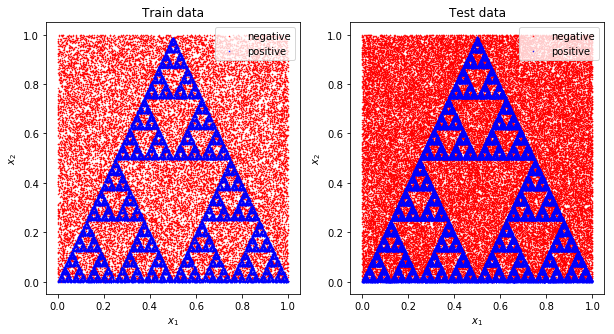

In [0]:
np.random.seed(5)

data_train = generate_fractals(50000, 10)
x_train = data_train[:,0:2]
y_train = data_train[:,-1]

data_vali = generate_fractals(10000, 10)
x_vali = data_vali[:,0:2]
y_vali = data_vali[:,-1]

data_test = np.loadtxt('Kaggle_test.txt', delimiter=',')
x_test = data_test[:,0:2]
y_test = data_test[:,-1]

_,ax = plt.subplots(1,2, figsize=(10,5))

print 'Train data size', x_train.shape
print 'Test data size', x_test.shape
print 'Validation data size', x_vali.shape

plot_data(x_train, y_train, ax[0], 'Train data')
plot_data(x_test, y_test, ax[1], 'Test data')

(3, 200)
1000: 0.868 / 0.863
2000: 0.875 / 0.858
3000: 0.879 / 0.875
4000: 0.881 / 0.872
5000: 0.883 / 0.880
6000: 0.886 / 0.879
7000: 0.886 / 0.879
8000: 0.888 / 0.882


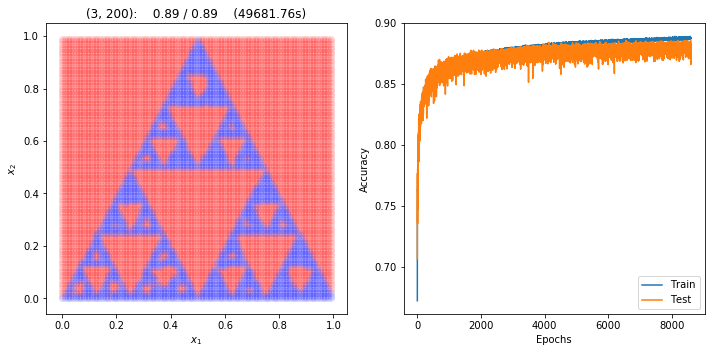

In [0]:
param = {}

param['dropout_rate'] = 0.0
param['learning_rate'] = 0.001
param['batch_size'] = 64
param['num_iterations'] = 100000
param['logging_epochs'] = 1000

param['num_layers'] = 3
param['num_hidden_nodes'] = 200

# Early stopping with check for convergence
param['use_convergence_test'] = True
param['last_model'] = False

print '(' + str(param['num_layers']) + ', ' + str(param['num_hidden_nodes']) + ')'

model, results, acc, val_acc, run_time =\
            fit_nn(x_train, y_train, x_vali, y_vali, x_test, y_test, param)

_, ax = plt.subplots(1, 2, figsize=(10,5))

plot_decision_boundary(x_test, y_test, model,\
                       '(' + str(param['num_layers']) + ', '\
                       + str(param['num_hidden_nodes']) + ')'\
                       + ':    ' + '{:.2f}'.format(acc)\
                       + ' / ' + '{:.2f}'.format(val_acc)\
                       + '    (' + '{:.2f}'.format(run_time) + 's)',\
                       ax[0])

plot_learning_curve(results, ax[1])

plt.tight_layout()

### Theoretical best accuracy for a Sierpinski triangle

In [ ]:
# Function to compute accuracy of theoretical best classifier
# a for Sierpinski triangle of scale $m$, on a given data set (x, y)
def best_accuracy(x, y, m):
    # Initial triangle vertices
    v1 = np.array([0,0])
    v2 = np.array([1,0])
    v3 = np.array([.5, 0.99])

    # Generate npos positive points over fractal
    n = x.shape[0]
    er = 0
    ypred = np.zeros(x.shape[0],)
    for i in range(n):
            ypred[i] = 1.0 * check_point(v1, v2, v3, x[i,:], m)
    return np.mean(y != ypred)


# Function to compute the midpoint of two points
def midpoint(point1, point2):
    return [(point1[0] + point2[0])/2., (point1[1] + point2[1])/2.]


# Function to compute the center of a triangle based on proportions alpha1, alpha2 and alpha3
def center(vertex1, vertex2, vertex3, alpha1, alpha2, alpha3):
    return [alpha1*vertex1[0] + alpha2*vertex2[0] + alpha3*vertex3[0],\
                   alpha1*vertex1[1] + alpha2*vertex2[1] + alpha3*vertex3[1]]


# Function to compute the L1 dist between two lines
def angle(line1, line2):
    return np.arccos(np.sum(line1 * line2) * 1.0 / norm_(line1) / norm_(line2))


# Function to compute the L1 dist between two lines
def norm_(line):
    return np.sqrt(line[0]*line[0] + line[1]*line[1])


# Function to check if point 'x' is within a triangle with vertices (v1, v2, v3) 
def is_inside(v1, v2, v3, x):
    totangle = angle(v1 - x, v2 - x) + angle(v2 - x, v3 - x)\
                    + angle(v3 - x, v1 - x)
    return True if (totangle > 6.28) and (totangle < 6.29) else False


# Function to check if point 'x' part of a Sierpinski triangle
#   generated at scale m, with vertices v1, v2, and v3
def check_point(v1, v2, v3, x, m):
    if not is_inside(v1, v2, v3, x):
        return False
    if m == 0:
        return True
    else:
        return check_point(v1, midpoint(v1, v2), midpoint(v1, v3), x, m-1)\
                | check_point(midpoint(v2, v1), v2, midpoint(v2, v3), x, m-1)\
                | check_point(midpoint(v3, v1), midpoint(v3, v2), v3, x, m-1)